In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *
import torchvision.models as tmodels

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from scipy.misc import imsave

from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.misc import imsave


import os
import sys

sys.path.insert(0, '/home/santhosr/Documents/Birad/FastAI/RaceClassification/' )

from utils import *

from birad import *
from birad import setTruthFile, getRaceLabel


In [2]:
inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)


df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
df2.Medview_Race = 'White'
truth = pd.concat([df1,df2],sort=True)

setTruthFile(truth)

In [3]:
dfFile = "DataFile9.csv"

modelName = 'model_resnet50_id9_acc848_loss376'


#Feature Directories
trainFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/Features/model9_2/train'

validFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/Features/model9_2/valid'

In [5]:
df = pd.read_csv(dfFile)

df.head()

,DummyID,filename,train
0,75218338,FullRes/3/75218338_R_CC_1.jpg,True
1,75145018,FullRes/2/75145018_R_MLO_1.jpg,True
2,75913007,PennExtra_3500/75913007_FOR-PROCESSING_L_CC_1.jpg,False
3,4632661,FullRes/2/4632661_R_CC_1.jpg,True
4,4011669,PennExtra_3500/4011669_FOR-PROCESSING_R_CC_1.jpg,False


### Extracting Features

In [6]:
#Creates the FastAI Dataset
data = ImageItemList.from_df(df=df,path='/home/santhosr/Documents/Birad/ProcessedData/', cols='filename').split_from_df(col='train').label_from_func(getRaceLabel).transform(get_transforms(),size=256).databunch(bs=50).normalize()
print("Dataset created")

Dataset created


##### Loading the model

In [7]:
#Creates the model architecture 
learn = create_cnn(data, tmodels.resnet50, metrics=accuracy,pretrained=True)

learn.load('/home/santhosr/Documents/Birad/ProcessedData/models/'+modelName)



Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (32000 items)
[Category 1, Category 1, Category 1, Category 1, Category 0]...
Path: /home/santhosr/Documents/Birad/ProcessedData
x: ImageItemList (32000 items)
[Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData;

Valid: LabelList
y: CategoryList (8000 items)
[Category 1, Category 1, Category 0, Category 0, Category 0]...
Path: /home/santhosr/Documents/Birad/ProcessedData
x: ImageItemList (8000 items)
[Image (3, 3328, 2560), Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inpl

In [ ]:
layer = list(learn.model.children())[1][4]

In [11]:
list(learn.model.children())[1][4]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [12]:
learn.model.eval()

#Setting the layer from which we are extracting features
layer = list(learn.model.children())[1][4]

my_embedding = 0

def copyData(m, inp, out):
    global my_embedding
    out1 = out.detach().cpu().numpy()
    my_embedding = out1

#Registering a forward hook
feat = layer.register_forward_hook(copyData)

##### Extracting Features (Train Data)

In [12]:
### Train Data

for i in tqdm(range(len(data.train_ds.items))):
    
    e=data.one_item(data.train_ds.x[i])
    pred = learn.model(e[0])
    
    file = data.train_ds.items[i].split("/")[-1].split(".")[0]
    
    np.save( os.path.join(trainFolder, file+'.npy'), my_embedding )
    
    
    
    


  0%|          | 114/28160 [00:29<1:42:21,  4.57it/s]

KeyboardInterrupt: 

##### Extracting Features (Valid Data)

In [14]:
### Valid Data

for i in tqdm(range(len(data.valid_ds.items))):
    
    e=data.one_item(data.valid_ds.x[i])
    pred = learn.model(e[0])
    
    file = data.valid_ds.items[i].split("/")[-1].split(".")[0]
    
    np.save( os.path.join(validFolder, file+'.npy'), my_embedding )
    
    
    
    

  2%|▏         | 141/8000 [00:34<30:00,  4.37it/s]

KeyboardInterrupt: 

In [17]:
generateFeatures(learn, data, trainFolder, validFolder)


  1%|          | 41/8000 [00:09<36:56,  3.59it/s]

KeyboardInterrupt: 

### Combined Modeling

In [1]:
train = df[df.train == False]
test = df[df.train == True]

trainy = train.label.copy()
testy = test.label.copy()

# keepList = ['VolumetricBreastDensity','DenseAreaPercent','Age','BMI']
# # keepList = ['DenseAreaPercent','Age','BMI']

# trainx = train[keepList]
# testx = test[keepList]

NameError: name 'df' is not defined

In [5]:
df.head()

,DummyID,filename,train
0,75426529,PennExtra_3500/75426529_FOR-PROCESSING_R_MLO_1...,False
1,75682563,FullRes/3/75682563_R_MLO_1.jpg,False
2,75761285,PennExtra_3500/75761285_FOR-PROCESSING_L_CC_1.jpg,False
3,4261353,FullRes/2/4261353_L_MLO_1.jpg,False
4,75456219,FullRes/2/75456219_R_MLO_1.jpg,True


In [6]:
truth.head()

,Age,BMI,Density_Overall,DummyID,Medview_Race,ScreenDate
0,67.8,27.1,2.0,2508626,White,3/23/2011
1,58.8,25.7,2.0,2505738,White,6/2/2011
2,56.4,28.1,2.0,2547962,White,5/24/2011
3,51.7,31.8,2.0,2575490,White,5/6/2011
4,63.7,27.5,2.0,2591080,Other,5/5/2011


In [25]:
df['label'] = df.filename.apply(lambda x : getRaceLabel(x))

df['DummyID'] = df.filename.apply(lambda x : int(x.split("/")[-1].split("_")[0]))

In [41]:
def extractImageName(x):
    
    x = x.split("/")[-1]
    
    if "MLO" in x :
        return x[-11:-6]
    else:
        return x[-10:-6]
    
df['ImageName'] = df.filename.apply(lambda x : x.split("/")[-1].split(".")[0])

In [42]:
truth.head()

,Age,BMI,Density_Overall,DummyID,Medview_Race,ScreenDate
0,67.8,27.1,2.0,2508626,White,3/23/2011
1,58.8,25.7,2.0,2505738,White,6/2/2011
2,56.4,28.1,2.0,2547962,White,5/24/2011
3,51.7,31.8,2.0,2575490,White,5/6/2011
4,63.7,27.5,2.0,2591080,Other,5/5/2011


In [28]:
df = pd.merge(df, truth[['DummyID','Age','BMI']], on='DummyID', how='left')

#Removing instances without BMI
df = df.loc[~pd.isna(df.BMI)]

In [33]:
df.label.value_counts()

1    16928
0    16636
Name: label, dtype: int64

### Patient Level Analysis

In [43]:
df.head()

,DummyID,filename,train,label,ImageName,Age,BMI
0,75426529,PennExtra_3500/75426529_FOR-PROCESSING_R_MLO_1...,False,1,75426529_FOR-PROCESSING_R_MLO_1,69.3,28.7
1,75682563,FullRes/3/75682563_R_MLO_1.jpg,False,0,75682563_R_MLO_1,52.4,32.7
2,75761285,PennExtra_3500/75761285_FOR-PROCESSING_L_CC_1.jpg,False,1,75761285_FOR-PROCESSING_L_CC_1,66.4,26.3
3,4261353,FullRes/2/4261353_L_MLO_1.jpg,False,0,4261353_L_MLO_1,66.8,32.4
4,75456219,FullRes/2/75456219_R_MLO_1.jpg,True,0,75456219_R_MLO_1,74.5,24.1


In [35]:

trainPatients = pd.unique(df.loc[df.train==False]['DummyID'])
validPatients = pd.unique(df.loc[df.train==True]['DummyID'])

dropList = []
for i in range(len(trainPatients)):
    d = df[df.DummyID == trainPatients[i]]
    if len(d)!=4:
        dropList.append(trainPatients[i])

trainPatients = list(set(trainPatients).difference(set(dropList)))


dropList = []
for i in range(len(validPatients)):
    d = df[df.DummyID == validPatients[i]]
    if len(d)!=4:
        dropList.append(validPatients[i])

validPatients = list(set(validPatients).difference(set(dropList)))    
    

In [36]:
len(trainPatients)

6693

In [37]:
len(validPatients)

1652

#### With Patient Data Alone

In [38]:
### Train data
trainData = []
trainLabel = []
for i in range(len(trainPatients)):
    
    r = df[df.DummyID==trainPatients[i]]
#     val = list(r['VolumetricBreastDensity'].values) + list(r['DenseAreaPercent'].values) + \
#             [r.iloc[0]['Age']] + [r.iloc[0]['BMI']]
    val =  [r.iloc[0]['Age']] + [r.iloc[0]['BMI']]
        
    trainData.append(val)
    trainLabel.append(r.iloc[0]['label'])
    
trainData = np.array(trainData)
trainLabel = np.array(trainLabel)

In [39]:
### Valid data
validData = []
validLabel = []
for i in range(len(validPatients)):
    
    r = df[df.DummyID==validPatients[i]]
    val =  [r.iloc[0]['Age']] + [r.iloc[0]['BMI']]
        
    validData.append(val)
    validLabel.append(r.iloc[0]['label'])
    
validData = np.array(validData)
validLabel = np.array(validLabel)

In [40]:
df.head()

,DummyID,filename,train,label,ImageName,Age,BMI
0,75426529,PennExtra_3500/75426529_FOR-PROCESSING_R_MLO_1...,False,1,R_MLO,69.3,28.7
1,75682563,FullRes/3/75682563_R_MLO_1.jpg,False,0,R_MLO,52.4,32.7
2,75761285,PennExtra_3500/75761285_FOR-PROCESSING_L_CC_1.jpg,False,1,L_CC,66.4,26.3
3,4261353,FullRes/2/4261353_L_MLO_1.jpg,False,0,L_MLO,66.8,32.4
4,75456219,FullRes/2/75456219_R_MLO_1.jpg,True,0,R_MLO,74.5,24.1


#### With Image Data

In [44]:
### Train data
trainData = []
trainLabel = []
for i in range(len(trainPatients)):
    
    r = df[df.DummyID==trainPatients[i]]
    r = r.sort_values('ImageName')
    
    val =  [r.iloc[0]['Age']] + [r.iloc[0]['BMI']]
    
    imageData = []
    for i in range(4):
        feat  = list(np.load(os.path.join(trainFolder,r.iloc[i]['ImageName']+'.npy')).reshape(-1))
        imageData = imageData + feat
    
    trainData.append(val+imageData)   #add val here for confounding vars
    trainLabel.append(r.iloc[0]['label'])
    
trainData = np.array(trainData)
trainLabel = np.array(trainLabel)

In [45]:
### valid data
validData = []
validLabel = []
for i in range(len(validPatients)):
    
    r = df[df.DummyID==validPatients[i]]
    r = r.sort_values('ImageName')
    
    val =       [r.iloc[0]['Age']] + [r.iloc[0]['BMI']]
    
    imageData = []
    for i in range(4):
        feat  = list(np.load(os.path.join(validFolder,r.iloc[i]['ImageName']+'.npy')).reshape(-1))
        imageData = imageData + feat
    
    validData.append(val +imageData )
    validLabel.append(r.iloc[0]['label'])
    
validData = np.array(validData)
validLabel = np.array(validLabel)

In [51]:
### MODELING


rfModel = RandomForestClassifier(n_estimators=300, max_depth=12)
rfModel.fit(trainData, trainLabel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
pred = rfModel.predict(validData)
accuracy_score(pred, validLabel)

0.8886198547215496

In [53]:
roc_auc_score(validLabel,pred)

0.8886315666041276

In [54]:
# CV Testing

scoreList = []

for i in tqdm(range(10)):
    rfModel = RandomForestClassifier(n_estimators=300, max_depth=10)
    rfModel.fit(trainData, trainLabel)
    
    pred = rfModel.predict(validData)
    score = roc_auc_score(pred, validLabel)
    
    scoreList.append(score)
    
print(np.mean(scoreList))
    
    

100%|██████████| 10/10 [06:07<00:00, 36.76s/it]

0.8878928206000325


### Keras Modeling

In [62]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras

inputShape = (2050,)

In [72]:
model = Sequential()


model.add(Dense(1024, activation='relu',input_shape=inputShape))
model.add(Dropout(0.6))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

In [73]:
epochs = 10

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(trainData, trainLabel,
          batch_size=50,
          epochs=epochs,
          verbose=1,
          validation_data=(validData, validLabel))

Train on 6693 samples, validate on 1652 samples
Epoch 1/10
6693/6693 [==============================] - 1s 207us/step - loss: 0.4066 - acc: 0.8921 - val_loss: 0.3446 - val_acc: 0.8801
Epoch 2/10
6693/6693 [==============================] - 1s 123us/step - loss: 0.2402 - acc: 0.9228 - val_loss: 0.3307 - val_acc: 0.8886
Epoch 3/10
6693/6693 [==============================] - 1s 124us/step - loss: 0.2030 - acc: 0.9355 - val_loss: 0.3084 - val_acc: 0.8898
Epoch 4/10
6693/6693 [==============================] - 1s 124us/step - loss: 0.1839 - acc: 0.9381 - val_loss: 0.3700 - val_acc: 0.8874
Epoch 5/10
6693/6693 [==============================] - 1s 123us/step - loss: 0.1763 - acc: 0.9398 - val_loss: 0.3109 - val_acc: 0.8959
Epoch 6/10
6693/6693 [==============================] - 1s 125us/step - loss: 0.1653 - acc: 0.9474 - val_loss: 0.3416 - val_acc: 0.8941
Epoch 7/10
6693/6693 [==============================] - 1s 125us/step - loss: 0.1504 - acc: 0.9501 - val_loss: 0.3879 - val_acc: 0.8953


#### Model 2

In [70]:
model = Sequential()


model.add(Dense(1024, activation='relu',input_shape=inputShape))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

In [71]:
epochs = 10

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(trainData, trainLabel,
          batch_size=50,
          epochs=epochs,
          verbose=1,
          validation_data=(validData, validLabel))

Train on 6693 samples, validate on 1652 samples
Epoch 1/10
6693/6693 [==============================] - 1s 181us/step - loss: 0.3685 - acc: 0.9000 - val_loss: 0.3670 - val_acc: 0.8729
Epoch 2/10
6693/6693 [==============================] - 1s 110us/step - loss: 0.2278 - acc: 0.9269 - val_loss: 0.3679 - val_acc: 0.8820
Epoch 3/10
6693/6693 [==============================] - 1s 110us/step - loss: 0.2192 - acc: 0.9311 - val_loss: 0.3391 - val_acc: 0.8826
Epoch 4/10
6693/6693 [==============================] - 1s 112us/step - loss: 0.2052 - acc: 0.9362 - val_loss: 0.3450 - val_acc: 0.8874
Epoch 5/10
6693/6693 [==============================] - 1s 110us/step - loss: 0.1953 - acc: 0.9353 - val_loss: 0.3355 - val_acc: 0.8856
Epoch 6/10
6693/6693 [==============================] - 1s 109us/step - loss: 0.1718 - acc: 0.9432 - val_loss: 0.3712 - val_acc: 0.8935
Epoch 7/10
6693/6693 [==============================] - 1s 110us/step - loss: 0.1718 - acc: 0.9450 - val_loss: 0.4069 - val_acc: 0.8929


### Making predictions for single images

In [37]:
from imageio import imread

img = imread('/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/75218338_R_CC_1.jpg')

In [63]:
df.head()

,DummyID,filename,train
0,75218338,FullRes/3/75218338_R_CC_1.jpg,True
1,75145018,FullRes/2/75145018_R_MLO_1.jpg,True
2,75913007,PennExtra_3500/75913007_FOR-PROCESSING_L_CC_1.jpg,False
3,4632661,FullRes/2/4632661_R_CC_1.jpg,True
4,4011669,PennExtra_3500/4011669_FOR-PROCESSING_R_CC_1.jpg,False


In [72]:
df1 = pd.DataFrame([['withLargerDataset/75218338_R_CC_1.jpg',False],['withLargerDataset/75218338_R_CC_11.jpg',False],['withLargerDataset/75218338_R_CC_12.jpg',True],['withLargerDataset/75218338_R_CC_13.jpg',False],['withLargerDataset/75218338_R_CC_14.jpg',True]])
df1.columns = ['filename','train']
df1.head()

,filename,train
0,withLargerDataset/75218338_R_CC_1.jpg,False
1,withLargerDataset/75218338_R_CC_11.jpg,False
2,withLargerDataset/75218338_R_CC_12.jpg,True
3,withLargerDataset/75218338_R_CC_13.jpg,False
4,withLargerDataset/75218338_R_CC_14.jpg,True


In [36]:
data.norm

functools.partial(<function _normalize_batch at 0x7f82240b1950>, mean=tensor([0.7549, 0.7549, 0.7549]), std=tensor([0.3382, 0.3382, 0.3382]), do_x=True, do_y=False)

In [31]:
data.valid_ds.items[0]

'/home/santhosr/Documents/Birad/ProcessedData/./FullRes/3/75218338_R_CC_1.jpg'

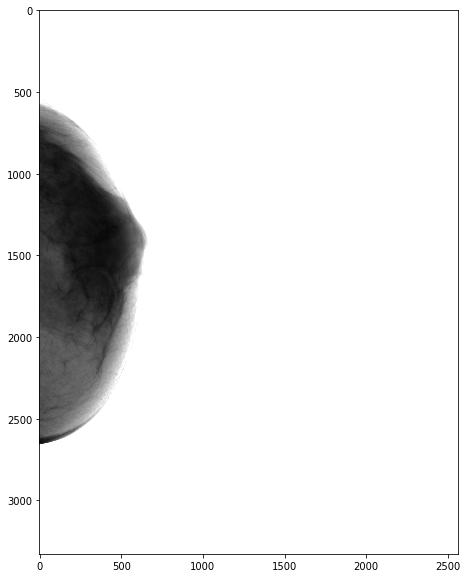

In [35]:
plotImageData('75218338_R_CC_1')

In [13]:
p=learn.predict(data.valid_ds.x[0])

In [14]:
p

(Category 1, tensor(1), tensor([0.0074, 0.9926]))

In [15]:
pred

tensor([[-2.0954,  2.8065]], device='cuda:0', grad_fn=<AddmmBackward>)

In [88]:
data.stats

[tensor([0.7549, 0.7549, 0.7549]), tensor([0.3382, 0.3382, 0.3382])]

In [164]:
import torch
import torchvision

from torchvision.transforms import ToTensor, Resize, Normalize

tfms = torchvision.transforms.Compose([
    Resize([256,256]),
    ToTensor(),
    Normalize(data.stats[0],data.stats[1])
    
    
])




In [165]:

img = PIL.Image.open('/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/75218338_R_CC_1.jpg').convert('RGB')

p = tfms(img)

In [100]:


#Creates the FastAI Dataset
data = ImageItemList.from_df(df=df,path='/home/santhosr/Documents/Birad/ProcessedData/', cols='filename').split_from_df(col='train').label_from_func(getRaceLabel).transform(get_transforms(),size=256).databunch(bs=50).normalize()
print("Dataset created")

Dataset created


In [101]:
q=data.valid_ds.x[0]

In [117]:
p.shape

torch.Size([3, 256, 256])

In [131]:
e=data.one_item(data.valid_ds.x[0])

In [118]:
e[0].shape

torch.Size([1, 3, 256, 256])

In [119]:
p[0,1:10,1:10]

tensor([[0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247]])

In [120]:
e[0][0,0,1:10,1:10]

tensor([[0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247],
        [0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247, 0.7247]],
       device='cuda:0')

In [121]:
p.unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [163]:
learn.model(p.unsqueeze(0).cuda())

tensor([[-2.6960,  2.6999]], device='cuda:0', grad_fn=<AddmmBackward>)

In [123]:
learn.model(p.unsqueeze(0).cuda())

tensor([[-2.6956,  2.6995]], device='cuda:0', grad_fn=<AddmmBackward>)

In [132]:
learn.model(e[0].cuda())

tensor([[-2.0954,  2.8065]], device='cuda:0', grad_fn=<AddmmBackward>)

In [125]:
data.tfms

[]

In [135]:
e[0]

tensor([[[[0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          ...,
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247]],

         [[0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          ...,
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247]],

         [[0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
          [0.7247, 0.7247, 0.7247,  ..., 0

In [136]:
p

tensor([[[0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         ...,
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247]],

        [[0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         ...,
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247]],

        [[0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.7247],
         [0.7247, 0.7247, 0.7247,  ..., 0.7247, 0.7247, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


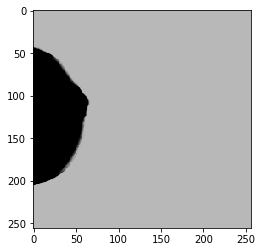

In [140]:
plt.imshow(np.transpose(p.numpy(),[1,2,0]))

In [166]:
np.max(p.numpy())

0.72472656

In [167]:
np.min(p.numpy())

-2.1049395

In [145]:
np.max(e[0].cpu().numpy())

0.72472656

In [147]:
np.min(e[0].cpu().numpy())

-2.131105

TypeError: 'module' object is not callable

In [169]:
from fastai.vision import Image

In [170]:
Image('/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/75218338_R_CC_1.jpg')

AttributeError: 'str' object has no attribute 'shape'

AttributeError: 'str' object has no attribute 'cpu'

AttributeError: 'str' object has no attribute 'cpu'

In [171]:
help(Image)

Help on class Image in module fastai.vision.image:

class Image(fastai.core.ItemBase)
 |  Support applying transforms to image data in `px`.
 |  
 |  Method resolution order:
 |      Image
 |      fastai.core.ItemBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, px:torch.Tensor)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  affine(self, func:Callable[[Dict[str, Any]], torch.Tensor], *args, **kwargs) -> 'Image'
 |      Equivalent to `image.affine_mat = image.affine_mat @ func()`.
 |  
 |  apply_tfms(self, tfms:Union[Callable, Collection[Callable]], do_resolve:bool=True, xtra:Union[Dict[Callable, dict], NoneType]=None, size:Union[int, Tuple[int, int, int], NoneType]=None, resize_method:fastai.vision.image.ResizeMethod=<ResizeMethod.CROP: 1>, mult:int=32, padding_mode:str='reflection', mode:str='bilinear') -> torch.Tensor
 |      Apply all `tfms` to the `Image`, if `do_re

In [172]:
help(type(Image))

Help on class type in module builtins:

class type(object)
 |  type(object_or_name, bases, dict)
 |  type(object) -> the object's type
 |  type(name, bases, dict) -> a new type
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __dir__(...)
 |      __dir__() -> list
 |      specialized __dir__ implementation for types
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __instancecheck__(...)
 |      __instancecheck__() -> bool
 |      check if an object is an instance
 |  
 |  __new__(*args, **kwargs)
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __prepare__(...)
 |      __prepare__() -> dict
 |      used to create the namespace for the class statement
 |  
 